In [92]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import xarray as xr

Estimates on 
* Charge efficiency
* Discharge efficiency
* losses


# Three different loss models

Steen et al. https://www.osti.gov/pages/servlets/purl/1163653  
Sizing of the tank (images)

(1) capacity model

$$loss = capacity \cdot soc \cdot lossrate$$

--------------------

(2) fully mixed model

$$loss = U \cdot A (T - T_{amb})$$

How does the area $A$ depend on $capacity$?

$$V = \frac{capacity}{c \rho (T_{max}-T_{amb})} \\
V = \pi r^2 h$$

Assume $h$ to be fixed, then

$$\pi r^2 = \frac{capacity}{h c \rho (T_{max}-T_{amb})} \\
A = 2 \pi r^2 + 2 \pi h$$

How does temperature $T$ depend on $soc$?

$$soc = \frac{T-T_{min}}{T_{max}-T_{min}}\\
T=soc(T_{max}-T_{min})+T_{min}$$

--------------------

(3) fully stratified model

$$V = \frac{capacity}{} \\
V = \pi r^2 h \\
A = 2 \pi r^2 + 2 \pi h \\
loss = U \cdot A (T - T_{amb})$$

In [265]:
def capacity_model(loss_rate, cap, soc):
    r"""
    Model the losses as a percentage of
    the total capacity.
    """
    soc *= 0.01
    loss = cap * soc * loss_rate
    return loss
    
def fully_mixed_model(U, temp_min, temp_max, temp_amb,
                      h, c, rho, cap, soc):
    r"""
    Model the losses dependent of
    the average temperature in a
    in a fully mixed tank.
    """
    soc *= 0.01
    pir2 = cap * 1/(h*c*rho*(temp_max - temp_amb))
    A = 2 * pir2 + 2 * np.pi * h
    temp = soc * (temp_max - temp_min) + temp_min
    print(temp)
    loss = U * A * (temp - temp_amb)
    return loss
    
def fully_stratified_model(U, temp_min, temp_max, temp_amb,
                               cap, soc):
    r"""
    Model the losses in a perfectly
    stratified tank with HT and LT
    section and state of charge given
    by the position of the boundary
    """
    P = cap
    r = cap
    H = 20
    loss_ht = (temp_max - temp_amb)*(P*(H-soc)+np.pi*r**2)*U
    loss_lt = (temp_min - temp_amb)*(P*soc+np.pi*r**2)*U
    loss = loss_ht + loss_lt
    return loss

def schuetz_model():
    return None

def piecewise_stratified_model():
    return None

In [270]:
def generic_sampling(input_dict, results_dict, function):
    r"""
    n-dimensional full sampling, storing as xarray.
    
    Parameters
    ----------
    input_dict : OrderedDict
        Ordered dictionary containing the ranges of the
        dimensions.
    
    results_dict : OrderedDict
        Ordered dictionary containing the dimensions and 
        coordinates of the results of the function.
        
    function : function
        Function to be sampled.
    
    Returns
    -------
    results : xarray.DataArray
    
    sampling : np.array
    
    indices : 
    """
    import itertools as it
    join_dicts = OrderedDict(list(input_dict.items()) + list(results_dict.items()))
    dims = join_dicts.keys()
    coords = join_dicts.values()
    results = xr.DataArray(np.empty([len(v) for v in join_dicts.values()]),
                           dims=dims,
                           coords=coords)

    sampling = np.array(list(it.product(*input_dict.values())))
    indices = np.array(list(it.product(*[np.arange(len(v)) for v in input_dict.values()])))
    
    for i in range(len(sampling)):
        result = function(*sampling[i])
        results[tuple(indices[i])] = result
        
    return results, sampling, indices

# sample capacity model
input_dict = OrderedDict([('loss_rate', [0.01]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_capacity_model = generic_sampling(input_dict, results_dict, capacity_model)[0]

# sample fully mixed model
input_dict = OrderedDict([('U', [0.01]),
                          ('temp_min', [65]),
                          ('temp_max', [95]),
                          ('temp_amb', [21]),
                          ('h', [2]),
                          ('c', [4.2]),
                          ('rho', [1]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_fully_mixed_model = generic_sampling(input_dict, results_dict, fully_mixed_model)[0]


# sample fully stratified model
input_dict = OrderedDict([('U', [0.5]),
                          ('temp_min', [65]),
                          ('temp_max', [95]),
                          ('temp_amb', [0]),
                          ('cap', np.arange(0, 10000, 1000)),
                          ('soc', np.arange(0, 110, 10))])

results_dict = dict([('results', ['loss'])])
sam_fully_stratified_model = generic_sampling(input_dict, results_dict, fully_stratified_model)[0]

65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0
65.0
68.0
71.0
74.0
77.0
80.0
83.0
86.0
89.0
92.0
95.0


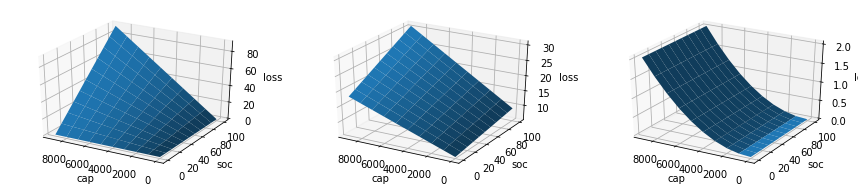

In [271]:
def add_3d_axes(fig, subplot_label, xcoord, ycoord, result):
    X, Y = np.meshgrid(xcoord, ycoord)
    ax = fig.add_subplot(subplot_label, projection='3d')
    ax.plot_surface(X, Y, result)
    ax.invert_xaxis()
    ax.set_xlabel(xcoord.name)
    ax.set_ylabel(ycoord.name)
    ax.set_zlabel('loss')
    return ax

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,3))
add_3d_axes(fig, 131, 
            sam_capacity_model.coords['cap'], 
            sam_capacity_model.coords['soc'], 
            sam_capacity_model.squeeze().values.T)
add_3d_axes(fig, 132, 
            sam_fully_mixed_model.coords['cap'], 
            sam_fully_mixed_model.coords['soc'], 
            sam_fully_mixed_model.squeeze().values.T)
add_3d_axes(fig, 133, 
            sam_fully_stratified_model.coords['cap'], 
            sam_fully_stratified_model.coords['soc'], 
            sam_fully_stratified_model.squeeze().values.T)

# Time evolution

In [136]:
timesteps = 100
soc = []
for t in timesteps:
    soc

SyntaxError: unexpected EOF while parsing (<ipython-input-136-dfac0a14145f>, line 2)

# Comparision to simulation models